## Table of Contents

1. [Preparation & Understanding the data structure](#prep)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#data)
4. [Defining the Model](#model)
5. [Training the Model](#train)
6. [Making & Visualising Predictions](#pred)

# Preparation & Understanding the data structure <a class="anchor" id="prep"></a>

### Importing packages

In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

import time
import copy
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print('Imports complete')

Imports complete


### Configurations

In [2]:
# Model Parameters
num_epochs = 10
batch_size = 128
num_classes = 2
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Loading and understanding the data structure

In [3]:
base_dir = '../input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [4]:
labels = pd.read_csv(base_dir + "train_labels.csv")
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [5]:
labels.shape

(220025, 2)

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


This file contains the ids of images for training and their labels for cancer. 

In [7]:
train_path = base_dir + "train/"
test_path = base_dir + "test/"
train_files = listdir(train_path)
test_files = listdir(test_path)

In [8]:
train_files[:5]

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif',
 '092d0eedebce504847715ee046b6ad74b57599b4.tif',
 'b0d2582c6218a8764323fc940b41312282b99bf4.tif',
 '187c99df762f13f99818e5593d4bab4c6577e7e3.tif',
 '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']

In [9]:
test_files[:5]

['a7ea26360815d8492433b14cd8318607bcf99d9e.tif',
 '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif',
 '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif',
 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif',
 '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif']

In [10]:
# Number of images in train and test
print("Train size: ", len(train_files))
print("Test size: ", len(test_files))

Train size:  220025
Test size:  57458


In [11]:
print((len(train_files)/(len(train_files)+len(test_files)))*100, (len(test_files)/(len(train_files)+len(test_files)))*100)

79.29314588641466 20.706854113585337


The directories train and test contain the actual images with 79.3% and 20.7% of the total images respectively.

In [12]:
sub = pd.read_csv(base_dir + "sample_submission.csv")
sub.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [13]:
sub.shape

(57458, 2)

In [14]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


This file contains the ids of test images and all the labels are set to 0. We need to modify the labels in this file according to our predictions.

# Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Visualizing the number of patches with cancer vs without cancer.

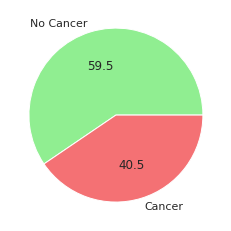

In [15]:
plt.pie(labels.label.value_counts(), labels=['No Cancer', 'Cancer'], colors=['#90EE91', '#F47174'], autopct='%1.1f')
plt.show()

### Visualizing healthy and cancer patches

In [16]:
positive_images = np.random.choice(labels[labels.label==1].id, size=50, replace=False)
negative_images = np.random.choice(labels[labels.label==0].id, size=50, replace=False)

**Cancer patches**

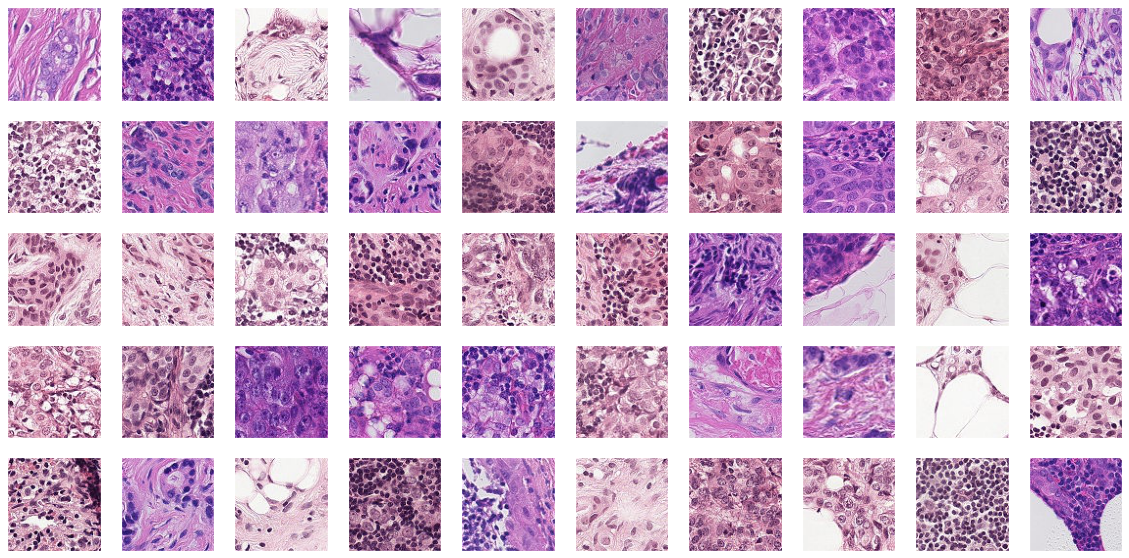

In [17]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = positive_images[m + n*10]
        image = Image.open(train_path + img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

**Healthy patches**

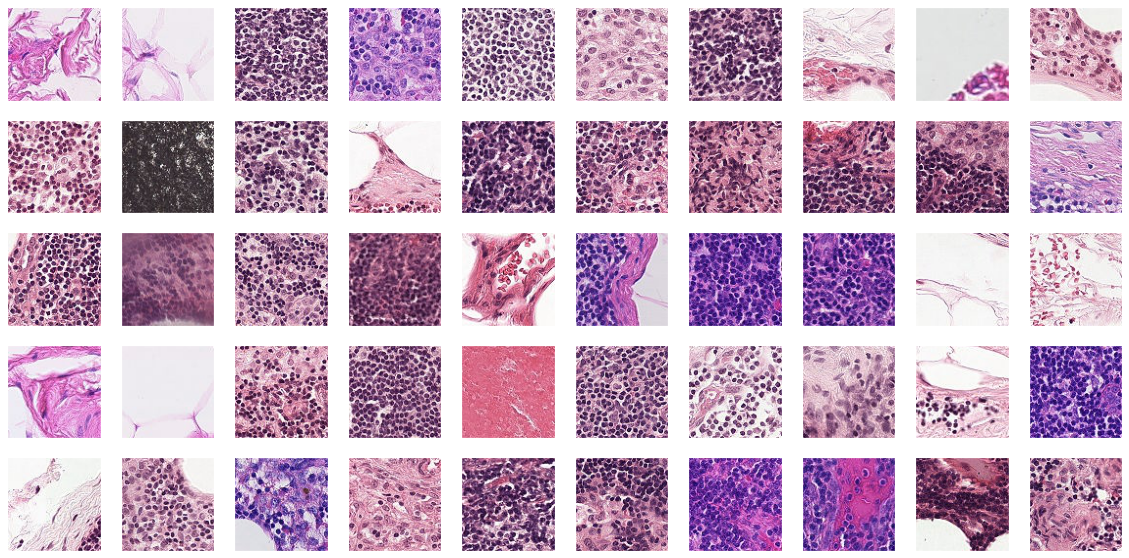

In [18]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = negative_images[m + n*10]
        image = Image.open(train_path + img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

**Analysis**

Visualising cancerous and healthy patches, it is hard to identify metastatic cancer for an untrained eye. One observation could be that the healthy patches have higher contrast than the cancerous patches. However, this observation doesn't seem to be applicable on all the images. It would be interesting to see what criterion pathologists use for identification of metastatic cancer!

# Data Preprocessing <a class="anchor" id="data"></a>

### Splitting the data into train and validation sets

In [19]:
train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)
print(len(train), len(val))

198022 22003


I have split the train data into train and validation sets in the ratio 9:1.

**Plotting the positive and negative ratio in train and val sets**

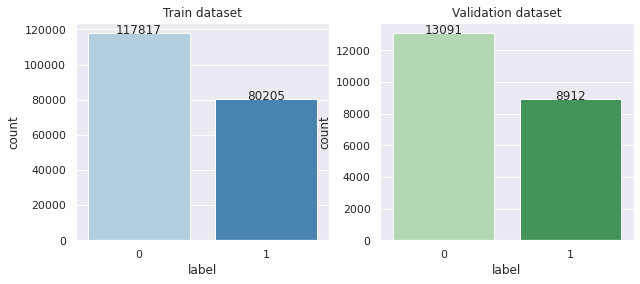

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(train.label, palette="Blues", ax=ax[0])
ax[0].set_title("Train dataset")
for i, rows in enumerate(train['label'].value_counts().values):
    ax[0].annotate(int(rows), xy=(i, rows), ha='center')
sns.countplot(val.label, palette="Greens", ax=ax[1])
ax[1].set_title("Validation dataset")
for i, rows in enumerate(val['label'].value_counts().values):
    ax[1].annotate(int(rows), xy=(i, rows), ha='center')

### Custom Dataset

I have created a dataset that loads an image patch, converts it to RGB, performs the augmentation if it's desired, and returns the image and its label.

In [21]:
class CancerDataset(Dataset):
    
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Data Augmentation

Now to increase the data size, I have applied transformation like flipping and rotation to the train dataset, and then converted the datasets into tensors.

In [22]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [23]:
train_dataset = CancerDataset(df_data=train, data_dir=train_path, transform=transform_train)
val_dataset = CancerDataset(df_data=val, data_dir=train_path, transform=transform_val)
test_dataset = CancerDataset(df_data=sub, data_dir=test_path, transform=transform_test)

### Creating pytorch dataloader

* The training data is shuffled after epochs so that the batches in the epochs are different every time and the model doesn't learn in a specific sequence.
* The last batch is dropped as it might contain less images than the batch size.

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

1547 171 449


# Defining the Model <a class="anchor" id="model"></a>

I am using a CNN as the model with 5 layers.

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3, 256),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, num_classes))
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
#        print(x.shape)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

Printing the training model.

In [27]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

### Loss and Optimizer

This task is a binary classification problem that has two classes, 1 for cancer positive images and 0 for cancer negative images. For loss function, I have used cross entropy loss.
I have used adam for optimizer.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

# Training the Model <a class="anchor" id="train"></a>

Building the training loop for the model. It prints the loss and accuracy for training and validation after each epoch.
For accuracy, I have calculated the area under the ROC curve between the predicted probability and the observed target.
The losses and accuracies are also saved in an array for further evaluation of the model.

In [29]:
train_losses = []
val_losses = []
train_auc = []
val_auc = []
train_auc_epoch = []
val_auc_epoch = []
best_acc = 0.0
min_loss = np.Inf

since = time.time()

for e in range(num_epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    
    # Train the model
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_dataloader, total=int(len(train_dataloader)))):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Loss and accuracy
        train_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred))
    
    # Evaluate the model
    model.eval()
    for i, (images, labels) in enumerate(tqdm(val_dataloader, total=int(len(val_dataloader)))):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Loss and accuracy
        val_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))
    
    # Average losses and accuracies
    train_loss = train_loss/len(train_dataloader)
    val_loss = val_loss/len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    training_auc = np.mean(train_auc)
    validation_auc = np.mean(val_auc)
    train_auc_epoch.append(training_auc)
    val_auc_epoch.append(validation_auc)
    
    # Updating best validation accuracy
    if best_acc < validation_auc:
        best_acc = validation_auc
        
    # Saving best model
    if min_loss >= val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        min_loss = val_loss
    
    print('EPOCH {}/{}'.format(e+1, num_epochs))
    print('-' * 10)
    print("Train loss: {:.6f}, Train AUC: {:.4f}".format(train_loss, training_auc))
    print("Validation loss: {:.6f}, Validation AUC: {:.4f}\n".format(val_loss, validation_auc))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation accuracy: {:4f}'.format(best_acc))

  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 1/10
----------
Train loss: 0.333041, Train AUC: 0.9179
Validation loss: 0.264933, Validation AUC: 0.9596



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 2/10
----------
Train loss: 0.249792, Train AUC: 0.9383
Validation loss: 0.333774, Validation AUC: 0.9611



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 3/10
----------
Train loss: 0.212781, Train AUC: 0.9490
Validation loss: 0.163256, Validation AUC: 0.9682



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 4/10
----------
Train loss: 0.191328, Train AUC: 0.9558
Validation loss: 0.211653, Validation AUC: 0.9694



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 5/10
----------
Train loss: 0.175456, Train AUC: 0.9606
Validation loss: 0.165111, Validation AUC: 0.9727



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 6/10
----------
Train loss: 0.160295, Train AUC: 0.9644
Validation loss: 0.174787, Validation AUC: 0.9744



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 7/10
----------
Train loss: 0.157974, Train AUC: 0.9671
Validation loss: 0.168022, Validation AUC: 0.9760



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 8/10
----------
Train loss: 0.150209, Train AUC: 0.9694
Validation loss: 0.194931, Validation AUC: 0.9760



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 9/10
----------
Train loss: 0.141605, Train AUC: 0.9714
Validation loss: 0.118717, Validation AUC: 0.9776



  0%|          | 0/1547 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

EPOCH 10/10
----------
Train loss: 0.137685, Train AUC: 0.9730
Validation loss: 0.118524, Validation AUC: 0.9788

Training completed in 110m 58s
Best validation accuracy: 0.978804


### Plotting training history

**Loss Convergence**

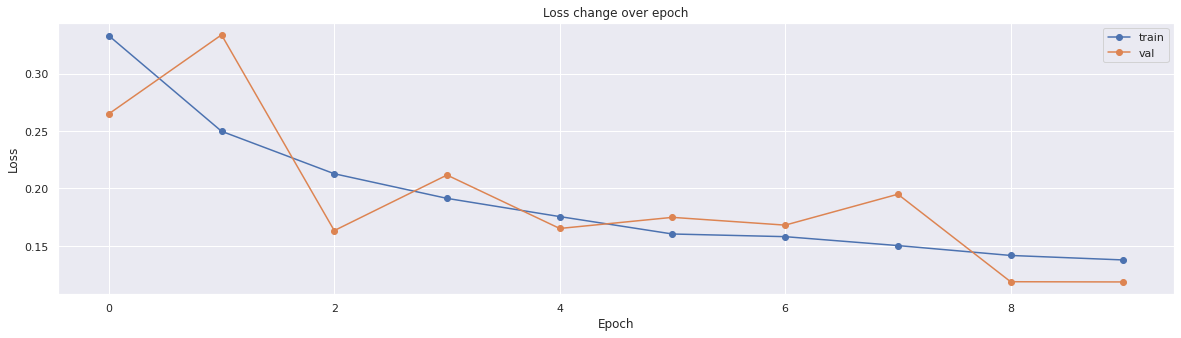

In [30]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

**Accuracy trend**

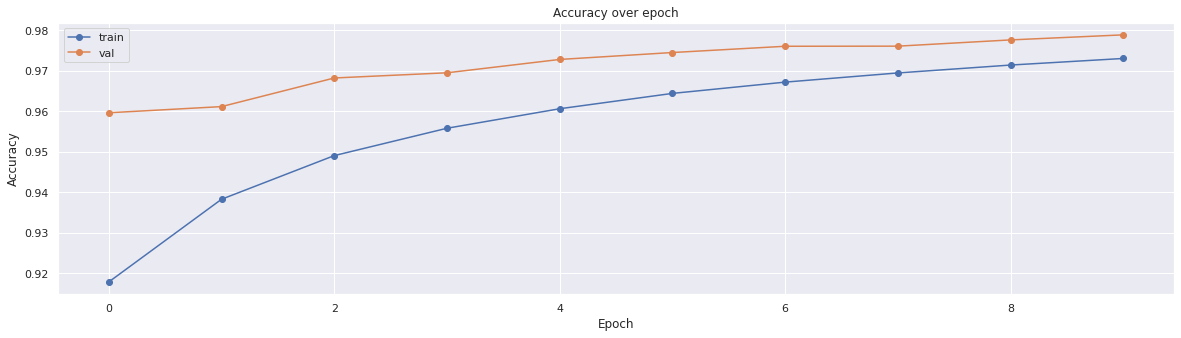

In [31]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

### Loading the best model

In [32]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

# Making & Visualising Predictions <a class="anchor" id="pred"></a>

### Predictions on test dataset

I have used my best model to make predictions on the test dataset.

In [33]:
model.eval()

predictions = []

for i, (images, labels) in enumerate(tqdm(test_dataloader, total=int(len(test_dataloader)))):
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    pred = outputs[:,1].detach().cpu().numpy()
    
    for j in pred:
        predictions.append(j)

  0%|          | 0/449 [00:00<?, ?it/s]

### Modifying the submission file

Now I am using the predictions made by the model to create a submission file.

In [34]:
sub['label'] = predictions
sub.to_csv('submission.csv', index=False)
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      57458 non-null  object 
 1   label   57458 non-null  float32
dtypes: float32(1), object(1)
memory usage: 673.5+ KB


### Visualising predictions

First I have written a function to convert the image from tensor and then displayed some of the test images along with their predicted result. For a probability less than 0.5, images are labelled 'Healthy', otherwise they are labelled 'Cancer'.

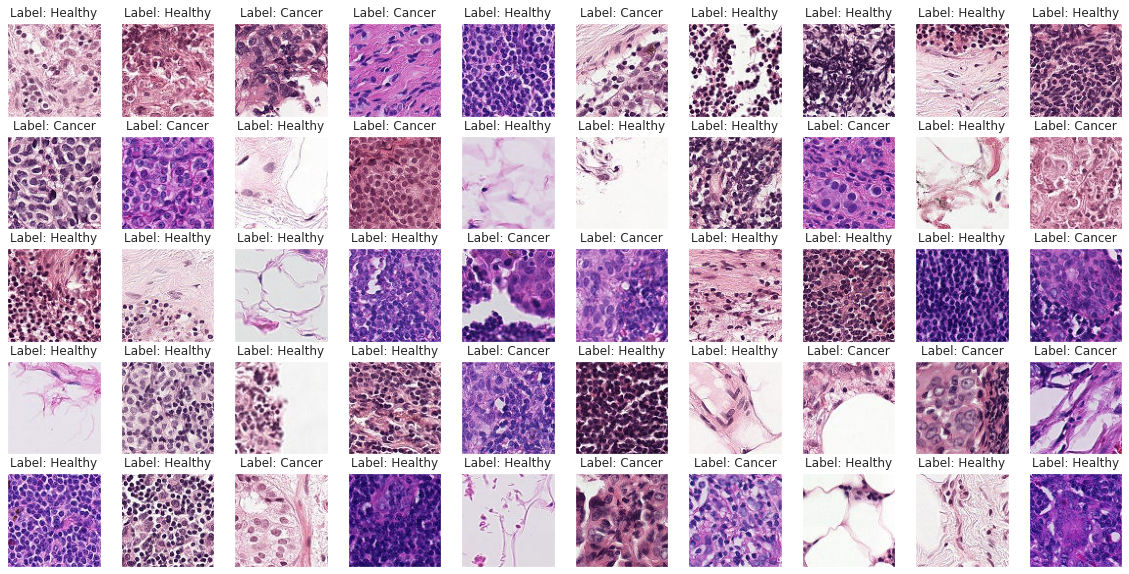

In [35]:
test_images = np.random.choice(sub.id, size=50, replace=False)     

fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = test_images[m + n*10]
        image = Image.open(test_path + img_id + ".tif")
        pred = sub.loc[sub['id'] == img_id, 'label'].values[0]
        label = "Cancer" if(pred >= 0.5) else "Healthy"  
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)
        ax[n,m].set_title("Label: " + label)